A phase diagram with the lowest energy configurations in islands with a ferromagnetic rim. This notebook follows the same procedure of the notebook for the phase diagram of islands with open boundaries:

# Import

In [1]:
import numpy as np
import os
import shutil
import glob
import re
from tqdm import tnrange, tqdm_notebook
import matplotlib

import matplotlib.pyplot as plt
plt.style.use('lato_style.mplstyle')

# Data

In [53]:
sim_dir = '/media/david/Boar/PdFeIr/hexagonal_system/relaxation/hexagons_phase_diagram_B_L_pinned_bs/'
top_charge_dir = '/media/david/Boar/PdFeIr/hexagonal_system/relaxation/hexagons_phase_diagram_B_L_pinned_bs/top_charges/'

In [54]:
energy_file_list = glob.glob(sim_dir + 'energies/*.txt')

In [55]:
def get_radius(f):
    return int(re.search('(?<=_R)\d+(?=e-1nm)', f).group(0))

def get_field(f):
    return int(re.search('(?<=_B).+(?=mT)', f).group(0))

def get_init_state(f):
    return re.search('(?<=mT_)[A-Z0-9]+(?=_E)', f).group(0)


In [56]:
data = {}

In [57]:
# for fpath in energy_file_list[:200]:
for i in tnrange(len(energy_file_list), desc='Energies'):
    fpath = energy_file_list[i]

    _file = os.path.basename(fpath)
    fpath_Q = os.path.join(top_charge_dir, _file.replace('_E.', '_Q.'))
    
    R = get_radius(_file)  # in 1e-1 nm
    B = get_field(_file)   # in mT
    IS = get_init_state(_file)
    
    if R == 10:
        print(fpath)
    
    if R not in data.keys():
        data[R] = {}
    
    if B not in data[R].keys():
        data[R][B] = {}
        
    if 'init_states' not in data[R][B].keys():
        data[R][B]['init_states'] = []
    if 'energies' not in data[R][B].keys():
        data[R][B]['energies'] =  np.array([])
    if 'Q' not in data[R][B].keys():
        data[R][B]['Q'] =  np.array([])
        
    if IS not in data[R][B]['init_states']:
        data[R][B]['init_states'].append(IS)
        data[R][B]['energies'] = np.append(data[R][B]['energies'],
                                           np.loadtxt(fpath)
                                           )
        data[R][B]['Q'] = np.append(data[R][B]['Q'],
                                    np.loadtxt(fpath_Q)
                                    )

In [58]:
for R in data.keys():
    if len(data[R].keys()) != len(range(0, 2001, 50)):
        print(R, B)
        print(data[R])

In [59]:
data_emin = {}

In [60]:
for R in range(40, 201, 5):
    if R not in data_emin.keys():
        data_emin[R] = {}
    
    for B in range(0, 2001, 50):
        if B not in data_emin[R].keys():
            data_emin[R][B] = {}

            min_energy = np.min(data[R][B]['energies'])
            state_idx = np.where(data[R][B]['energies'] == min_energy)[0][0]

            data_emin[R][B]['energy_min'] = min_energy
            data_emin[R][B]['Q'] = data[R][B]['Q'][state_idx]
            data_emin[R][B]['state_min'] = data[R][B]['init_states'][state_idx]
        

In [ ]:
data_emin[40]

# Q number plot

In [61]:
Q_plot_data = []

for B in range(2000, -1, -50):
    R_data = []
    for R in range(40, 201, 5):
        R_data.append(data_emin[R][B]['Q'])
    
    Q_plot_data.append(R_data)
    
Q_plot_data = np.array(Q_plot_data)

In [62]:
ccmap = matplotlib.colors.ListedColormap(['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c',
                                         '#fdbf6f', '#ff7f00', '#cab2d6', '#6a3d9a', '#ffff99', '#b15928'])

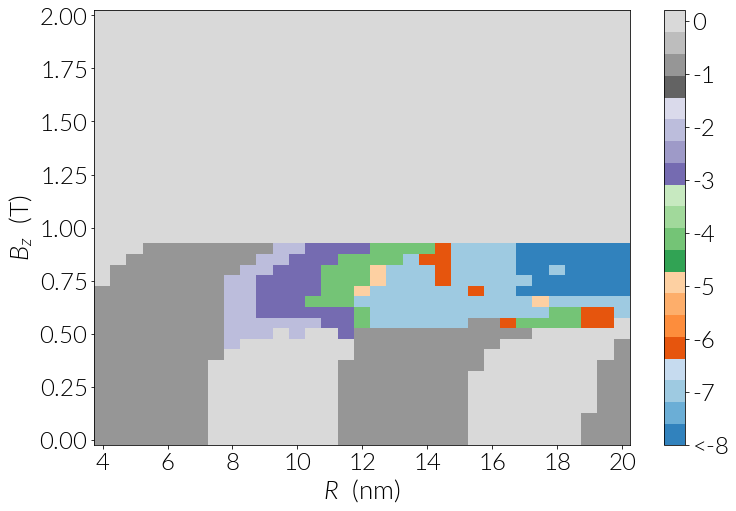

In [32]:
plt.figure(figsize=(12, 8))

plt.imshow(Q_plot_data, cmap='tab20c',
           aspect='auto',
           extent=[4 - 0.25, 20 + 0.25, 
                   0 - 0.025, 2 + 0.025],
           vmin=-8, vmax=0.2
           )
c = plt.colorbar()
c.set_ticks([i for i in np.arange(0, -8.1, -1)])
c.set_ticklabels(['{:.0f}'.format(i) for i in np.arange(0, -7.1, -1)] + ['<-8'])

plt.ylabel(r'$B_{z}$  (T)')
plt.xlabel(r'$R$  (nm)')

plt.xticks([4, 6, 8, 10, 12, 14, 16, 18, 20])

# plt.savefig('PdFeIr_phase_diagram_Q.pdf', bbox_inches='tight')
plt.show()

(-0.025, 1.025)

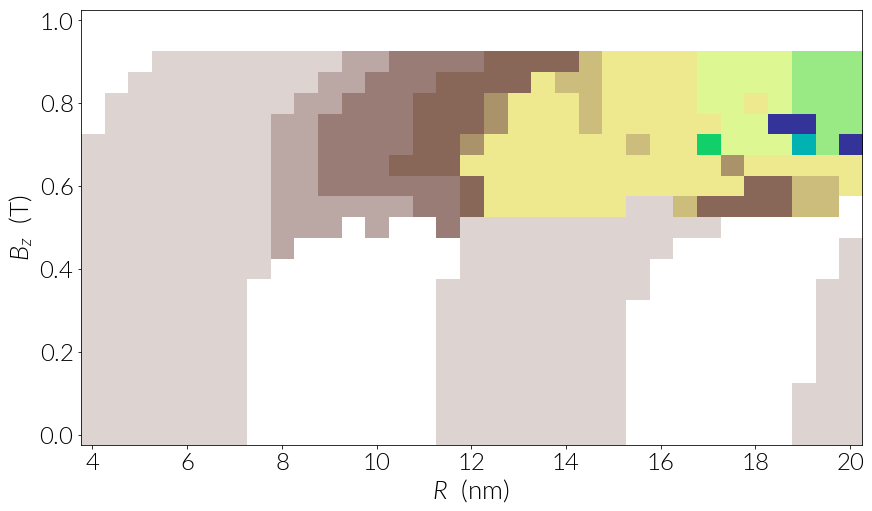

In [33]:
plt.figure(figsize=(14, 8))

plt.imshow(Q_plot_data, cmap='terrain',
           aspect='auto',
           extent=[4 - 0.25, 20 + 0.25, 
                   0 - 0.025, 2 + 0.025])
# c = plt.colorbar()

plt.ylabel(r'$B_{z}$  (T)')
plt.xlabel(r'$R$  (nm)')

plt.xticks([4, 6, 8, 10, 12, 14, 16, 18, 20])

plt.ylim(0-0.025, 1+0.025)

# plt.savefig('PdFeIr_phase_diagram_Q_pinned_bs.pdf', bbox_inches='tight')

# Images of lower energy states

In [15]:
Rs = range(40, 201, 5)
Bs = range(2000, -1, -50)

In [43]:
pngs_dir = '/media/david/Boar/PdFeIr/hexagonal_system/relaxation/pngs_pinned_bs/'

In [ ]:
f, axs = plt.subplots(ncols=len(Rs), nrows=len(Bs), figsize=(14, 16))
ax_grid = axs.flatten()

i = -1
for B in Bs:
    for R in Rs:
        # B = 650
        i += 1

        st = data_emin[R][B]['state_min']
        sim_name = 'PdFe-Ir_hexagon_R{}e-1nm_B{}mT_{}'.format(R, B, st)
        png_file = pngs_dir + '{}.png'.format(sim_name)

        if not os.path.exists(png_file):
            continue

        im = plt.imread(png_file)
        ax_grid[i].imshow(im, aspect='auto')
    
for ax in ax_grid:
    ax.set_xticks([])
    ax.set_yticks([])
    
base_i = (len(Bs) - 1) * len(Rs)
for j, i in enumerate(range(0, len(Rs), 8)):
    ax = ax_grid[base_i + i]
    lbl = 4 + j * 4
    ax.set_xlabel('{}'.format(lbl), fontsize=24)
    
    if j == 2:
        ax.text(0.5, -1.25, r'$R$  (nm)',
            horizontalalignment='center',
            verticalalignment='top',
            transform=ax.transAxes,
            fontsize=24, rotation=0
            )
    
for j, i in enumerate(range(0, len(Bs) * len(Rs) - 1, 5 * len(Rs))):
    ax = ax_grid[i]
    lbl = 2.0 - 0.05 * 5 * j
    # ax_grid[i].set_ylabel('{:.2f}'.format(lbl), rotation=0)
    
    ax.text(0., 0.45, '{:.2f}'.format(lbl),
            horizontalalignment='right',
            verticalalignment='center',
            transform=ax.transAxes,
            fontsize=24
            )
    
    if j == 4:
        ax.text(-2.25, 0.5, r'$B_z$  (T)',
            horizontalalignment='right',
            verticalalignment='center',
            transform=ax.transAxes,
            fontsize=24, rotation=90
            )
        

# plt.savefig('PdFeIr_phase_diagram_pinned_bs.png', bbox_inches='tight', dpi=300)

In [19]:
list(Bs)[20:]

[1000,
 950,
 900,
 850,
 800,
 750,
 700,
 650,
 600,
 550,
 500,
 450,
 400,
 350,
 300,
 250,
 200,
 150,
 100,
 50,
 0]

In [47]:
pngs_dir = '/media/david/Boar/PdFeIr/hexagonal_system/relaxation/pngs_pinned_bs_GB/'

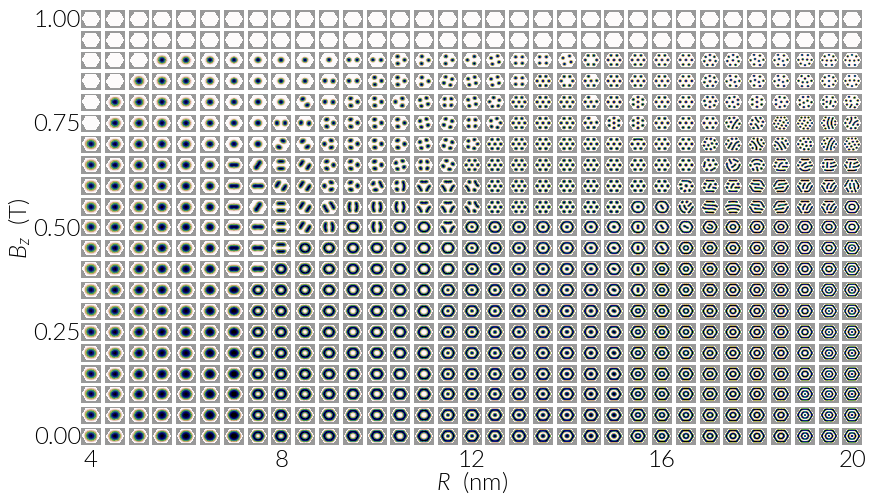

In [67]:
f, axs = plt.subplots(ncols=len(Rs), nrows=len(Bs[20:]), figsize=(14, 8))
ax_grid = axs.flatten()

i = -1
for B in Bs[20:]:
    for R in Rs:
        # B = 650
        i += 1

        st = data_emin[R][B]['state_min']
        sim_name = 'PdFe-Ir_hexagon_R{}e-1nm_B{}mT_{}'.format(R, B, st)
        png_file = pngs_dir + '{}.png'.format(sim_name)

        if not os.path.exists(png_file):
            continue

        im = plt.imread(png_file)
        ax_grid[i].imshow(im, aspect='auto')
    
for ax in ax_grid:
    ax.set_xticks([])
    ax.set_yticks([])
    for loc in ['top', 'bottom', 'left', 'right']:
        ax.spines[loc].set_visible(False)
    
base_i = (len(Bs[20:]) - 1) * len(Rs)
for j, i in enumerate(range(0, len(Rs), 8)):   
    ax = ax_grid[base_i + i]
    lbl = 4 + j * 4
    ax.set_xlabel('{}'.format(lbl), fontsize=24)
    
    if j == 2:
        ax.text(0.5, -1.4, r'$R$  (nm)',
            horizontalalignment='center',
            verticalalignment='top',
            transform=ax.transAxes,
            fontsize=24, rotation=0
            )
    
for j, i in enumerate(range(0, len(Bs[20:]) * len(Rs) - 1, 5 * len(Rs))):
    ax = ax_grid[i]
    lbl = 1.0 - 0.05 * 5 * j
    # ax_grid[i].set_ylabel('{:.2f}'.format(lbl), rotation=0)
    
    ax.text(0., 0.45, '{:.2f}'.format(lbl),
            horizontalalignment='right',
            verticalalignment='center',
            transform=ax.transAxes,
            fontsize=24
            )
    
    if j == 2:
        ax.text(-2.4, 0.5, r'$B_z$  (T)',
            horizontalalignment='right',
            verticalalignment='center',
            transform=ax.transAxes,
            fontsize=24, rotation=90
            )
        

plt.savefig('PdFeIr_phase_diagram_pinned_bs_CUT.png', bbox_inches='tight', dpi=300)
# plt.savefig('tmp.png', bbox_inches='tight', dpi=300)